In [59]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [239]:
# data prep from https://www.kaggle.com/adityasharma01/ts-ridge-rf-by-as
path = 'data/'
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

# Oil moving average

data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(data_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)

# Day of week

calendar['dofw'] = calendar.index.dayofweek

# Events

df_hev = pd.read_csv(path + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_hev['date'] = df_hev['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction

df_hev = df_hev.set_index('date').sort_index()
df_hev = df_hev[df_hev.locale == 'National'] # National level only for simplicity
df_hev = df_hev.groupby(df_hev.index).first() # Keep one event only

# Work days

calendar['wd'] = True
calendar.loc[calendar.dofw > 4, 'wd'] = False

calendar = calendar.merge(df_hev, how='left', left_index=True, right_index=True)

calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True
                                         
df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       # dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       dtype={'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_train = df_train.merge(calendar.reset_index().rename({'index': 'date'}, axis=1), on='date')
# df_train.date = df_train.date.dt.to_period('D')
# df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()
                                         
df_test = pd.read_csv(path + 'test.csv',
                      usecols=['store_nbr', 'family', 'date', 'id', 'onpromotion'],
                      # dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)

df_test = df_test.merge(calendar.reset_index().rename({'index': 'date'}, axis=1), on='date')
# df_test.date = df_test.date.dt.to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
                                         
sdate = '2017-04-01'
edate = '2017-08-15'

In [9]:
!ls data

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv		     stores.csv		    train.csv


In [195]:
pd.read_csv('data/train.csv')

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [10]:
df_store = pd.read_csv('data/stores.csv')
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
print(f'store_nbr: {df_train["store_nbr"].nunique()}')
print(f'family:    {df_train["family"].nunique()}')

store_nbr: 54
family:    33


In [ ]:
df_train['sales'].describe()

In [ ]:
calendar

In [ ]:
# ma_oil_bins

In [ ]:
_, ma_oil_bins = pd.qcut(df_train['ma_oil'].fillna(0), 10, retbins=True)

pd.cut(df_train['ma_oil'].fillna(0), ma_oil_bins, include_lowest=True)

In [204]:
df_train_pvt = df_train.pivot(index='date', columns=['store_nbr', 'family'], values=['sales', 'onpromotion']).sort_index()
df_train_pvt
# from datetime import timedelta
# remove leading 0-sales
# df_train_pvt.columns
# for c in df_train_pvt.columns:
#     df_train_pvt[c].loc[:df_train_pvt[c].ne(0).idxmax()-timedelta(days=1)] = np.nan

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2013-01-01         0.0      0.0    0.0    0.000000  ...         0.0   0.0   
2013-01-02         0.0   1060.0  579.0  164.069000  ...         0.0   0.0   
2013-01-03         0.0    836.0  453.0  151.582001  ...         0.0   0.0   
2013-01-04         0.0    827.0  460.0  131.410995  ...         0.0   0.0   
2013-01-05         0.0    811.0  464.0  118.612999  ...         0.0   0.0   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...         0.0   0.0   
2017-08-12         3.0    351.0  526.0   99.487999  ...         0.0   0.0   
2017-08-13         1.0    169.0  266.0   47.770000  ...         0.0   0.0   
2017-08-14         4.0    571.0  699.0  154.578003  ...         0.0   0.0   
2017-08-15        21.0    703.0  602.0  116.402000  ...         0.0   0.0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2013-01-01           0.0          0.0                     0.0     0.0   
2013-01-02           0.0          0.0                     0.0     0.0   
2013-01-03           0.0          0.0                     0.0     0.0   
2013-01-04           0.0          0.0                     0.0     0.0   
2013-01-05           0.0          0.0                     0.0     0.0   
...                  ...          ...                     ...     ...   
2017-08-11          11.0          0.0                     0.0    22.0   
2017-08-12           7.0          0.0                     0.0     0.0   
2017-08-13           9.0          0.0                     0.0     0.0   
2017-08-14          10.0          0.0                     0.0     0.0   
2017-08-15          11.0          0.0                     0.0     0.0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2013-01-01            0.0     0.0                        0.0     0.0  
2013-01-02            0.0     0.0                        0.0     0.0  
2013-01-03            0.0     0.0                        0.0     0.0  
2013-01-04            0.0     0.0                        0.0     0.0  
2013-01-05            0.0     0.0                        0.0     0.0  
...                   ...     ...                        ..

In [ ]:
def featurize_lgb(df):
   return pd.DataFrame({
        # 'seasonal' : (df['date'] - min_date).dt.days // 90,
        'store'    : df['store_nbr'].astype("category"),
        'item'     : df['family'].astype("category"),
        'date_weekday'   : df['date'].dt.month,
        'date_month'     : df['date'].dt.dayofweek,
        # 'onpromotion'    : df['onpromotion'],
#         'city'     : df['city'],
#         'state'    : df['state'],
#         'type'     : df['type'],
#         'cluster'  : df['cluster'],
        # NaNs
        # 'store_month'     : df['store_nbr'].astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'item_month'      : df['family'].astype(str)    + '_' + df['date'].dt.month.astype(str),
        # 'store_X_dayofweek'     : df['store_nbr'].astype("category").cat.codes.astype(str) + '_' + df['date'].dt.dayofweek.astype(str),
        # 'item_X_dayofweek'      : df['family'].astype("category").cat.codes.astype(str)    + '_' + df['date'].dt.dayofweek.astype(str),
        # 'store_item' : df['family'].astype(str) + '_' + df['store_nbr'].astype(str),
       
        # 'dayofweek': df['date'].dt.dayofweek.values,
        # 'dayofyear': df['date'].dt.dayofyear.values,
        # 'month'    : df['date'].dt.month.values,
        # 'type'     : df['type'].fillna('Unknown').astype('category').cat.codes,
        # 'ma_oil'   : pd.cut(df['ma_oil'].fillna(0), ma_oil_bins, include_lowest=True).cat.codes
        # 'ma_oil'   : df['ma_oil'],
        # 'dofw'     : df['dofw'].fillna('Unknown').astype("category").cat.codes,
    })

#     # LightGBM
#     x_train = featurize_lgb(yX_train)
#     x_test  = featurize_lgb(yX_test)
    
#     train_data = lgb.Dataset(x_train, label=np.log1p(yX_train['sales']))
#     param = {'num_leaves': 31, 'objective': 'regression', 'metric': 'rmse'}
    
#     bst = lgb.train(param, train_data)
    
#     y_pred_test = np.expm1(bst.predict(x_test))
#     rmsle = mean_squared_log_error(yX_test['sales'], np.maximum(y_pred_test, 0), squared=False)
#     back_testing_lgb.append(rmsle)
    
#     print(f'rmsle: {rmsle}')
    

In [213]:

    print(train_index)

[   0    1    2 ... 1606 1607 1608]
[   0    1    2 ... 1621 1622 1623]
[   0    1    2 ... 1636 1637 1638]
[   0    1    2 ... 1651 1652 1653]
[   0    1    2 ... 1666 1667 1668]


In [219]:
df_train[df_train['date'].isin(dates[train_index])].merge(df_store, on='store_nbr')

,date,store_nbr,family,sales,onpromotion,dcoilwtico,ma_oil,dofw,wd,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,2013-01-01,1,AUTOMOTIVE,0.000000,0,NaN,NaN,1,False,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,2013-01-01,1,BABY CARE,0.000000,0,NaN,NaN,1,False,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
2,2013-01-01,1,BEAUTY,0.000000,0,NaN,NaN,1,False,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
3,2013-01-01,1,BEVERAGES,0.000000,0,NaN,NaN,1,False,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
4,2013-01-01,1,BOOKS,0.000000,0,NaN,NaN,1,False,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2867233,2017-06-01,9,POULTRY,535.961975,0,48.32,50.107143,3,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6
2867234,2017-06-01,9,PREPARED FOODS,98.870003,0,48.32,50.107143,3,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6
2867235,2017-06-01,9,PRODUCE,1536.501953,0,48.32,50.107143,3,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6
2867236,2017-06-01,9,SCHOOL AND OFFICE SUPPLIES,3.000000,0,48.32,50.107143,3,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6


rmsle: 0.7205779117129867 in -0.00029991299379616976
rmsle: 0.7130693214699029 in -5.145899922354147e-05
rmsle: 0.7120638013826535 in -0.0007706760006840341
rmsle: 0.7257127048557661 in -2.473700442351401e-05
rmsle: 0.74898184875726 in -0.00011629299842752516
Median 0.7205779117129867
Avg    0.7240811176357138


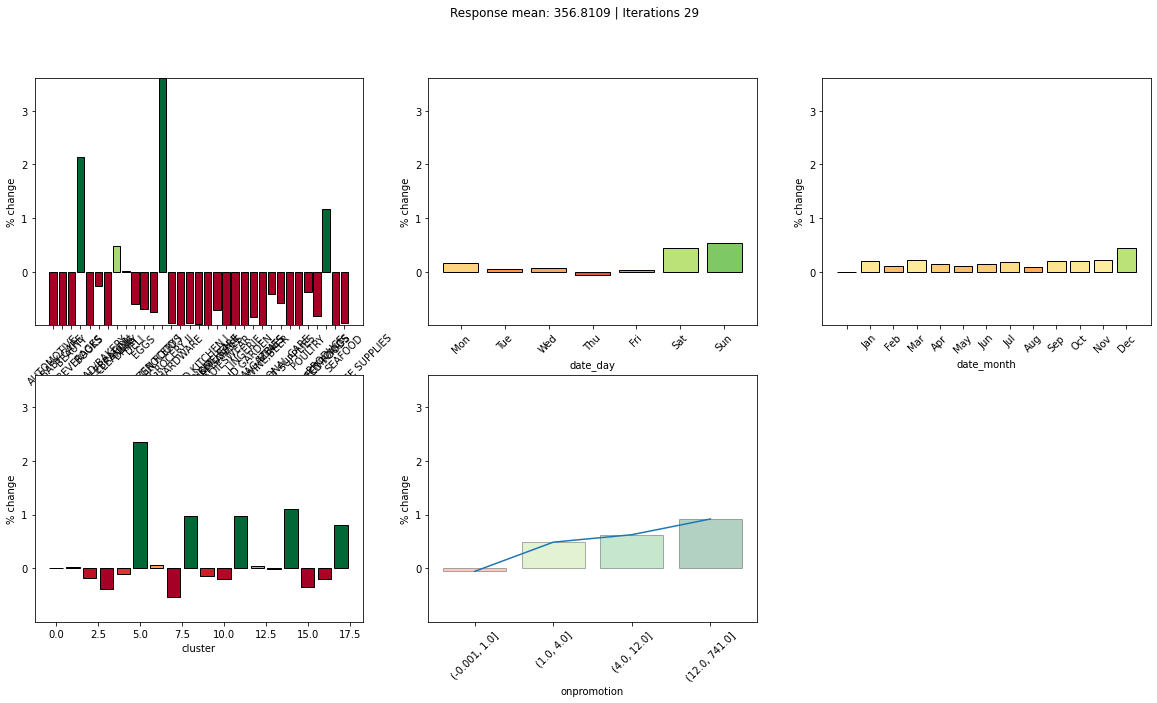

In [228]:
import lightgbm as lgb
import cbm
import timeit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

min_date = df_train.date.min()

def featurize(df):
   return pd.DataFrame({
#         'seasonal' : (df['date'] - min_date).dt.days // 90,
        # 'store'    : df['store_nbr'], #.astype("category").cat.codes, 
        'item'     : df['family'], # .astype("category").cat.codes, 
        'date'     : df['date'],
#         'city'     : df['city'],
#         'state'    : df['state'],
#         'type'     : df['type'],
       'cluster'  : df['cluster'],
       'onpromotion'    : df['onpromotion'].astype(float),
        # NaNs
        # 'store_month'     : df['store_nbr'].astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'item_month'      : df['family'].astype(str)    + '_' + df['date'].dt.month.astype(str),
        # 'store_X_dayofweek'     : df['store_nbr'].astype("category").cat.codes.astype(str) + '_' + df['date'].dt.dayofweek.astype(str),
        # 'item_X_dayofweek'      : df['family'].astype("category").cat.codes.astype(str)    + '_' + df['date'].dt.dayofweek.astype(str),
        # 'store_item' : df['family'].astype(str) + '_' + df['store_nbr'].astype(str),
       
        # 'dayofweek': df['date'].dt.dayofweek.values,
        # 'dayofyear': df['date'].dt.dayofyear.values,
        # 'month'    : df['date'].dt.month.values,
        # 'type'     : df['type'].fillna('Unknown').astype('category').cat.codes,
        # 'ma_oil'   : pd.cut(df['ma_oil'].fillna(0), ma_oil_bins, include_lowest=True).cat.codes
        # 'ma_oil'   : df['ma_oil'],
        # 'dofw'     : df['dofw'].fillna('Unknown').astype("category").cat.codes,
    })


tscv = TimeSeriesSplit(n_splits=5, test_size=15)

# df_train_pvt
back_testing = []
back_testing_lgb = []
# for train_index, test_index in tscv.split(df_train_pvt):
dates = df_train['date'].unique()
for train_index, test_index in tscv.split(dates):
    start = timeit.timeit()
    # yX_train = df_train_pvt.iloc[train_index].unstack().reset_index().rename({0: 'sales'}, axis=1).merge(df_store)
    # yX_test  = df_train_pvt.iloc[test_index] .unstack().reset_index().rename({0: 'sales'}, axis=1).merge(df_store)
    yX_train = df_train[df_train['date'].isin(dates[train_index])].merge(df_store, on='store_nbr')
    yX_test  = df_train[df_train['date'].isin(dates[test_index])].merge(df_store, on='store_nbr')

    
    # valid = ~yX_train['sales'].isna()
    
    # print(yX_train)
    # x_train = featurize(yX_train[valid])
    x_train = featurize(yX_train)
    x_test  = featurize(yX_test)
    
    
    model = cbm.CBM(binning=20) # metric='l1', min_iterations_early_stopping=40, epsilon_early_stopping=1e-5) #binning = lambda _: 3)
    # model.fit(x_train, yX_train['sales'][valid])
    model.fit(x_train, yX_train['sales'])
    
    # estimate seasonal effect
#     y_dummy = np.array(model.weights[0])
#     y_dummy_ts = pd.Series(y_dummy)

#     fh = np.arange(-len(y_dummy_ts)+1, # cover the training period
#                    x_test['seasonal'].max() + 2 - len(y_dummy_ts) # cover the test period
#                   )

#     forecaster = ExponentialSmoothing(trend="add") #, seasonal="multiplicative", sp=4)
#     forecaster.fit(y_dummy_ts)
#     y_pred = forecaster.predict(fh=fh)
    
#     plot_series(y_dummy_ts, y_pred)
    
#     w = model.weights
#     w[0] = y_pred
#     model.update(w, model.y_mean)
    
    y_pred_test = model.predict(x_test).flatten()

    # test on train error
    rmsle = mean_squared_log_error(yX_test['sales'].fillna(0), y_pred_test, squared=False)
    back_testing.append(rmsle)
    end = timeit.timeit()
    
    print(f'rmsle: {rmsle} in {end - start}')
   
    

print(f'Median {np.median(back_testing)}')
print(f'Avg    {np.mean(back_testing)}')

# print(f'Median {np.median(back_testing_lgb)}')

model.plot_importance(figsize=(20,10))

In [230]:
yX_test['pred'] = y_pred_test
yX_test['error'] = np.square(np.log1p(yX_test['sales']) - np.log1p(yX_test['pred']))
yX_test

,date,store_nbr,family,sales,onpromotion,dcoilwtico,ma_oil,dofw,wd,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,pred,error
0,2017-08-01,1,AUTOMOTIVE,5.000000,0,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,4.938130,0.000107
1,2017-08-01,1,BABY CARE,0.000000,0,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.419986,0.122953
2,2017-08-01,1,BEAUTY,4.000000,0,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,3.119056,0.037564
3,2017-08-01,1,BEVERAGES,2627.000000,26,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,2419.970533,0.006733
4,2017-08-01,1,BOOKS,0.000000,0,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13,0.355890,0.092694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26725,2017-08-15,9,POULTRY,438.132996,0,47.57,48.648571,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6,252.535812,0.301727
26726,2017-08-15,9,PREPARED FOODS,154.552994,1,47.57,48.648571,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6,75.716531,0.499664
26727,2017-08-15,9,PRODUCE,2419.729004,148,47.57,48.648571,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6,1806.825929,0.085231
26728,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000000,8,47.57,48.648571,1,True,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,B,6,3.980960,10.229751


In [144]:
yX_test.pivot_table(index=['store_nbr'], columns=[], values=['error'], aggfunc=[np.median, 'count']).sort_values(('median', 'error'), ascending=False).head()

,median,count
,error,error
store_nbr,,
54,0.302811,495
14,0.295256,495
32,0.282914,495
13,0.258926,495
43,0.247714,495


In [145]:
yX_test.query('store_nbr == 52').pivot_table(index=['family'], columns=[], values=['error'], aggfunc=[np.median, 'count']).sort_values(('median', 'error'), ascending=False).head()

,median,count
,error,error
family,,
LAWN AND GARDEN,2.198309,15
SEAFOOD,2.110656,15
HOME APPLIANCES,0.837816,15
BOOKS,0.556357,15
PLAYERS AND ELECTRONICS,0.407820,15


In [231]:
yX_test.query('store_nbr == 52 and family == "LAWN AND GARDEN"')

,date,store_nbr,family,sales,onpromotion,dcoilwtico,ma_oil,dofw,wd,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,pred,error
23285,2017-08-01,52,LAWN AND GARDEN,26.0,0,49.19,48.675714,1,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,9.551881,0.882722
23318,2017-08-02,52,LAWN AND GARDEN,61.0,9,49.60,49.160000,2,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,16.737586,1.566123
23351,2017-08-03,52,LAWN AND GARDEN,79.0,0,49.03,49.340000,3,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,8.594847,4.497795
23384,2017-08-04,52,LAWN AND GARDEN,65.0,0,49.57,49.481429,4,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,9.462758,3.392348
23417,2017-08-05,52,LAWN AND GARDEN,69.0,0,NaN,49.481429,5,False,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,13.100172,2.567391
23450,2017-08-06,52,LAWN AND GARDEN,45.0,0,NaN,49.481429,6,False,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,14.040534,1.249684
23483,2017-08-07,52,LAWN AND GARDEN,41.0,1,49.37,49.527143,0,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,10.537105,1.669526
23516,2017-08-08,52,LAWN AND GARDEN,51.0,0,49.07,49.434286,1,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,9.551881,2.543832
23549,2017-08-09,52,LAWN AND GARDEN,38.0,9,49.59,49.345714,2,True,NaN,NaN,NaN,NaN,NaN,Manta,Manabi,A,11,16.737586,0.620748
23582,2017-08-10,52,LAWN AND GARDEN,35.0,0,48.54,49.252857,3,True,Holiday,National,Ecuador,Primer Grito de Independencia,True,Manta,Manabi,A,11,8.594847,1.748458


In [188]:
yX_test.query('family == "LAWN AND GARDEN"').pivot_table(index=['cluster', 'store_nbr'], columns='date', values=['sales']) #.sort_values('cluster', ascending=False)

sales                                              \
date              2017-08-01 2017-08-02 2017-08-03 2017-08-04 2017-08-05   
cluster store_nbr                                                          
1       24              30.0       51.0       26.0       40.0       60.0   
        25              13.0       35.0       17.0       15.0       42.0   
        27              34.0       33.0       28.0       41.0       40.0   
2       37              19.0       41.0       29.0       23.0       27.0   
        42              43.0       31.0       39.0       36.0       36.0   
3       16               0.0        0.0        0.0        0.0        0.0   
        30               0.0        0.0        0.0        0.0        0.0   
        32               0.0        0.0        0.0        0.0        0.0   
        33               0.0        0.0        0.0        0.0        0.0   
        35               0.0        0.0        0.0        0.0        0.0   
        40               0.0        0.0        0.0        0.0        1.0   
        54               0.0        0.0        0.0        0.0        0.0   
4       5                5.0       12.0        6.0       18.0       11.0   
        38              17.0       29.0       19.0       17.0       36.0   
        41              18.0       26.0       17.0       15.0       20.0   
5       44              25.0       42.0       20.0       26.0       48.0   
6       9               15.0        5.0        9.0        2.0        5.0   
        11               2.0        1.0        5.0        5.0        3.0   
        20              14.0       11.0        8.0        5.0        5.0   
        21               8.0        5.0        4.0        1.0        6.0   
        34               4.0        4.0        7.0        8.0       11.0   
        39              13.0        9.0       15.0       25.0       13.0   
7       14               0.0        0.0        0.0        0.0        0.0   
        22               0.0        0.0        0.0        0.0        0.0   
8       3               71.0       79.0       32.0       65.0       65.0   
        7               42.0       21.0       38.0       38.0       67.0   
        8               26.0       44.0       16.0       27.0       53.0   
9       4               19.0       30.0       10.0       28.0       24.0   
        23               0.0        2.0        2.0        1.0        4.0   
10      26               0.0        9.0        5.0       21.0       10.0   
        28               9.0       12.0        5.0        1.0        2.0   
        29               9.0        7.0        3.0        4.0       20.0   
        31               5.0        6.0        2.0        0.0        2.0   
        36              22.0       28.0       35.0       16.0       60.0   
        43               5.0       11.0       17.0       11.0       13.0   
11      45              28.0       36.0       40.0       58.0       73.0   
        49              28.0       27.0       21.0       62.0       34.0   
        52              26.0       61.0       79.0       65.0       69.0   
12      17               0.0        0.0        0.0        0.0        0.0   
13      1               22.0       31.0       10.0       17.0       17.0   
        2               18.0       20.0       15.0       21.0       13.0   
        6                5.0       20.0       13.0        8.0       26.0   
        53              17.0       16.0        5.0        7.0       15.0   
14      46              21.0       24.0       13.0       33.0       32.0   
        47              15.0       22.0       27.0       47.0       31.0   
        48               2.0       15.0        7.0       15.0       10.0   
        50               5.0       18.0        8.0       10.0       13.0   
15      10               0.0        0.0        0.0        0.0        0.0   
        12               0.0        0.0        0.0        0.0        0.0   
        13               0.0        0.0        0.0        0.0        0.

In [107]:
df_train.query('store_nbr == 52 and family == "LAWN AND GARDEN"')['sales'].reset_index(drop=True).iloc[1566:]

1566    52.0
1567    43.0
1568    79.0
1569    53.0
1570    10.0
        ... 
1679    78.0
1680    86.0
1681    59.0
1682    43.0
1683    54.0
Name: sales, Length: 118, dtype: float32

<AxesSubplot:xlabel='date'>

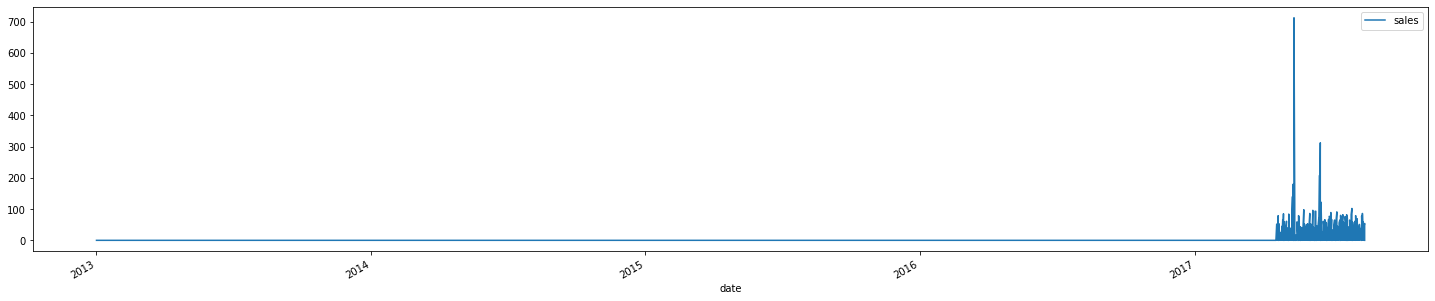

In [232]:
df_train_pvt.unstack().reset_index().rename({0: 'sales'}, axis=1).merge(df_store).query('store_nbr == 52 and family == "LAWN AND GARDEN"').plot('date', 'sales', figsize=(25, 5))

In [89]:
df_train_pvt.unstack().reset_index().rename({0: 'sales'}, axis=1).merge(df_store).query('store_nbr == 52 and family == "LAWN AND GARDEN"')

,level_0,store_nbr,family,date,sales,city,state,type,cluster
2645564,sales,52,LAWN AND GARDEN,2013-01-01,0.0,Manta,Manabi,A,11
2645565,sales,52,LAWN AND GARDEN,2013-01-02,0.0,Manta,Manabi,A,11
2645566,sales,52,LAWN AND GARDEN,2013-01-03,0.0,Manta,Manabi,A,11
2645567,sales,52,LAWN AND GARDEN,2013-01-04,0.0,Manta,Manabi,A,11
2645568,sales,52,LAWN AND GARDEN,2013-01-05,0.0,Manta,Manabi,A,11
...,...,...,...,...,...,...,...,...,...
2647243,sales,52,LAWN AND GARDEN,2017-08-11,78.0,Manta,Manabi,A,11
2647244,sales,52,LAWN AND GARDEN,2017-08-12,86.0,Manta,Manabi,A,11
2647245,sales,52,LAWN AND GARDEN,2017-08-13,59.0,Manta,Manabi,A,11
2647246,sales,52,LAWN AND GARDEN,2017-08-14,43.0,Manta,Manabi,A,11


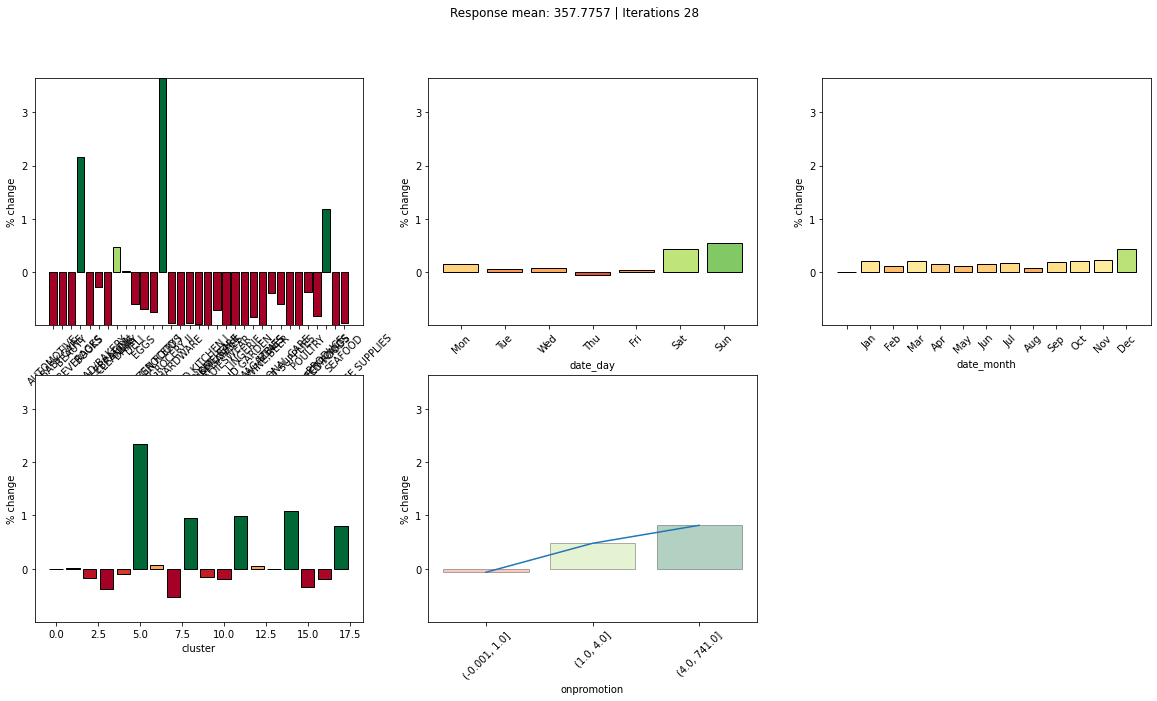

In [235]:
yX_train = df_train.merge(df_store, on='store_nbr')

# yX_train = df_train_pvt.unstack().reset_index().rename({0: 'sales'}, axis=1).merge(df_store)

# valid = ~yX_train['sales'].isna()

# x_train = featurize(yX_train[valid])
x_train = featurize(yX_train)
    
model = cbm.CBM() 
# model.fit(x_train, yX_train['sales'][valid])
model.fit(x_train, yX_train['sales']) #[valid])

model.plot_importance(figsize=(20,10))

In [237]:
y_pred_train = model.predict(x_train).flatten()

# mean_squared_log_error(yX_train['sales'][valid], y_pred_train, squared=False)
mean_squared_log_error(yX_train['sales'], y_pred_train, squared=False)

1.7144530119320085

In [240]:
# submit

x_test  = featurize(df_test.drop('type', axis=1).merge(df_store))
df_test['sales'] = model.predict(x_test).flatten()
df_test.set_index('id')[['sales']].to_csv('submission.csv', index=True)

In [241]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m v1

100%|█████████████████████████████████████████| 736k/736k [00:02<00:00, 262kB/s]
Successfully submitted to Store Sales - Time Series Forecasting

2.2802909184654947


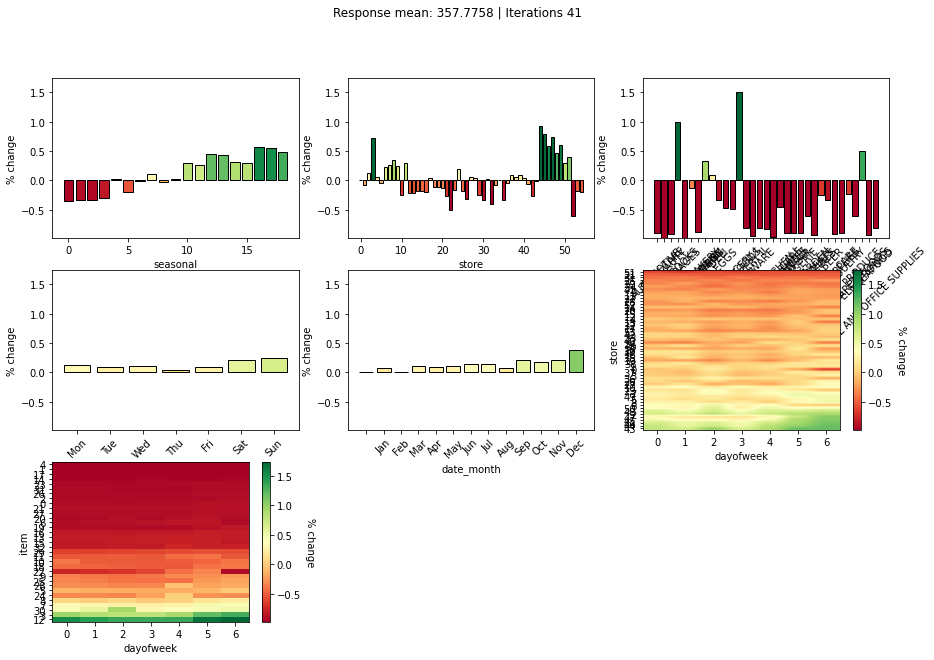

In [15]:
import cbm
from sklearn.metrics import mean_squared_log_error

### features
min_date = df_train.date.min()
# _, ma_oil_bins = pd.qcut(df_train['ma_oil'].fillna(0), 5, retbins=True)

def featurize(df):
   return pd.DataFrame({
        'seasonal' : (df['date'] - min_date).dt.days // 90,
        'store'    : df['store_nbr'], #.astype("category").cat.codes, 
        'item'     : df['family'], # .astype("category").cat.codes, 
        'date'     : df['date'],
        # NaNs
        # 'store_month'     : df['store_nbr'].astype(str) + '_' + df['date'].dt.month.astype(str),
        # 'item_month'      : df['family'].astype(str)    + '_' + df['date'].dt.month.astype(str),
        'store_X_dayofweek'     : df['store_nbr'].astype("category").cat.codes.astype(str) + '_' + df['date'].dt.dayofweek.astype(str),
        'item_X_dayofweek'      : df['family'].astype("category").cat.codes.astype(str)    + '_' + df['date'].dt.dayofweek.astype(str),
        # 'store_item' : df['family'].astype(str) + '_' + df['store_nbr'].astype(str),
       
        # 'dayofweek': df['date'].dt.dayofweek.values,
        # 'dayofyear': df['date'].dt.dayofyear.values,
        # 'month'    : df['date'].dt.month.values,
        # 'type'     : df['type'].fillna('Unknown').astype('category').cat.codes,
        # 'ma_oil'   : pd.cut(df['ma_oil'].fillna(0), ma_oil_bins, include_lowest=True).cat.codes
        # 'ma_oil'   : df['ma_oil'],
        # 'dofw'     : df['dofw'].fillna('Unknown').astype("category").cat.codes,
    })


x_train_df = featurize(df_train)
x_test_df  = featurize(df_test)

x_train = x_train_df # .to_numpy().astype('uint8')
x_test  = x_test_df #.to_numpy().astype('uint8')
y_train = df_train['sales']
# y_test  = test['sales']

### training
model = cbm.CBM(metric='l1', min_iterations_early_stopping=40, epsilon_early_stopping=1e-5) #binning = lambda _: 3)
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train).flatten()

# test on train error
print(mean_squared_log_error(y_train, y_pred_train))

#### plotting
model.plot_importance(figsize=(15, 10))
# 2.402653144918136
# 2.3801564352203695
# 2.3021129846711794

In [ ]:
# hyperparams = np.array(np.meshgrid(learning_rate_step_size, max_iterations, min_iterations_early_stopping)).T.reshape(-1,3)
def cartesian_product(d):
    index = pd.MultiIndex.from_product(d.values(), names=d.keys())
    return pd.DataFrame(index=index).reset_index()

hp = cartesian_product({
    'learning_rate_step_size': [1/100, 1/200],
    'max_iterations': [50, 100, 200],
    'min_iterations_early_stopping': [10, 20, 40]    
})

def train_eval(r):
    model = cbm.CBM(
        learning_rate_step_size = r['learning_rate_step_size'],
        max_iterations = int(r['max_iterations']),
        min_iterations_early_stopping = int(r['min_iterations_early_stopping']))
    
    #**kwargs)
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train).flatten()

    # test on train error
    metric = mean_squared_log_error(y_train, y_pred_train)
    print(metric)
    
    return metric

hp['metric'] = hp.apply(lambda r: train_eval(r.to_dict()), axis=1)
hp

In [102]:
model = cbm.CBM(
        learning_rate_step_size = 1/40,
        max_iterations = 100,
        min_iterations_early_stopping = 20
)
    
model.fit(x_train, y_train)

y_pred_train = model.predict(x_train).flatten()

# test on train error
print(mean_squared_log_error(y_train, y_pred_train))

2.3241800200198566


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

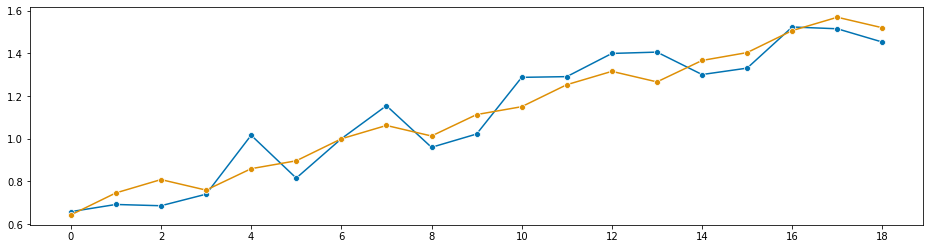

In [32]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.utils.plotting import plot_series

y_dummy = np.array(model.weights[0])
y_dummy_ts = pd.Series(y_dummy)

fh = np.arange(-len(y_dummy_ts)+1, # cover the training period
               x_test_df['seasonal'].max() + 2 - len(y_dummy_ts) # cover the test period
              )

forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=5)
forecaster.fit(y_dummy_ts)
y_pred = forecaster.predict(fh=fh)

plot_series(y_dummy_ts, y_pred)

In [33]:
# model_smooth = cbm.CBM()

w = model.weights
w[0] = y_pred
model.update(w, model.y_mean)

y_pred_train_smooth = model.predict(x_train).flatten()

# test on train error
print(mean_squared_log_error(y_pred_train_smooth, y_train))
print(mean_squared_log_error(y_pred_train, y_train))

# y_pred_test = model_smooth.predict(x_test).flatten()

2.329658486692809
2.304544600607954


In [17]:
y_pred_test = model.predict(x_test).flatten()

In [18]:
df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = y_pred_test
df_sub.to_csv('submission.csv', index=True)

In [19]:
!kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m v1

100%|█████████████████████████████████████████| 736k/736k [00:02<00:00, 254kB/s]
Successfully submitted to Store Sales - Time Series Forecasting